<a href="https://colab.research.google.com/github/mateosuster/nlpPapers/blob/main/code/04_LDA_Preliminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import pandas as pd

import re

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import numpy as np

# Data

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data.csv")
data.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS


## Limpieza, Normalizacion y Tokenización.

In [5]:
## DEFINIMOS FUNCIONES DE LIMPIEZA Y DE TOKENIZACION:
# The isinstance() function returns True if the specified object is of the specified type, otherwise False.
# \W: Matchea caracteres que NO sean alfanuméricos; equivalente a[^a-zA-Z0-9_].
# \d: Matchea digitos; equivalente a [0-9]
# "+": Matchea 1 o mas ocurrencias

def clean_text(text):
    #Para poder aplicarlo a todo el corpus (lista) #(data.ABSTRACT[0:10]):
    if isinstance(text, pd.Series):     
        # return text.str.replace('[^A-Za-z0-9]+', ' ', regex = True).str.lower().str.strip().values
        return text.str.replace('\W+', ' ', regex = True).str.lower().str.strip().str.replace('\d+', '').values
    
    #Para poder aplicarlo a 1 texto en particular (str) #(data.ABSTRACT[0]):
    elif isinstance(text, str):         
        return re.sub('\d+', '',  re.sub('[^A-Za-z0-9]+', ' ' , text.lower()).strip())

def tokenizer(text):
    #return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
    return word_tokenize(str(text))  ###***OJO: ESTA TOKENIZANDO TODO UN GRAN TEXTO PLANO (LA LISTA DE TEXTOS LA TRANSFORMO EN 1 SOLO TEXTO GIGANTE) 
    
    # if isinstance(text, str):
    #     return word_tokenize(text)
    # else:
    #     return text.apply(word_tokenize)



In [7]:
clean_text(data.ABSTRACT[0])
#type(data.ABSTRACT[0:10])  #pandas.core.series.Series

'text worlds are virtual environments for embodied agents that unlike d or d environments are rendered exclusively using textual descriptions these environments offer an alternative to higher fidelity d environments due to their low barrier to entry providing the ability to study semantics compositional inference and other high level tasks with rich action spaces while controlling for perceptual input this systematic survey outlines recent developments in tooling environments and agent modeling for text worlds while examining recent trends in knowledge graphs common sense reasoning transfer learning of text world performance to higher fidelity environments as well as near term development targets that once achieved make text worlds an attractive general research paradigm for natural language processing'

In [8]:
#### APLICAMOS LA FUNCION DE LIMPIEZA A TODO EL CORPUS, SOLO A LOS ABSTRACTS:
# EL PROBLEMA ES: *COMO GUARDAR EL TRACKEO DE A QUE AUTOR, PUBLISHER, YEAR, ETC, ESTABA ASOCIADO CADA ABSTRACT***
# ***EN EL CLEAN NO SE PIERDE, PERO SI SE VA A PERDER EN EL TOKENIZADO (PORQ SE DESARMA EN UNA LISTA DE PALABRAS).***
# *ENTONCES CREO UN CAMPO NUEVO CON EL ABSTRACT LIMPIADO:
data = data.assign(ABSTRACT_CL = clean_text(data.ABSTRACT))
#clean_text(data.ABSTRACT)
#type(clean_text(data.ABSTRACT))  #numpy.ndarray
#print(clean_text(data.ABSTRACT))
data.ABSTRACT_CL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


0        text worlds are virtual environments for embod...
1        a prototype system for playing a minimal impro...
2        non player characters npcs significantly enhan...
3        interactive question answering iqa requires an...
4        the purpose of this extended abstract is to di...
                               ...                        
33806    this paper deals with the problem of represent...
33807    it becomes more and more evident that successf...
33808    establishing the grammatical description of a ...
33809    a grammar based upon a conventional morphemic ...
33810    we used to think that the output of a translat...
Name: ABSTRACT_CL, Length: 33811, dtype: object

In [9]:
# word_tokenize(clean_text(data.ABSTRACT))
len(tokenizer(data.ABSTRACT_CL))  #106 (!!!!)
#type(tokenizer(clean_text(data.ABSTRACT)))  #list
#tokenizer(data.ABSTRACT_CL)[:5]  # ['0', 'text', 'worlds', 'are', 'virtual']
#tokenizer(clean_text(data.ABSTRACT))[:5]  # ['[', "'text", 'worlds', 'are', 'virtual']
#tokenizer(data.ABSTRACT_CL)[105]  # ['32245', ',', 'dtype', ':', 'object']
#tokenizer(clean_text(data.ABSTRACT))[105]  # ['to', 'parsing', 'time', "'", ']']

107

In [10]:
len(tokenizer(clean_text(data.ABSTRACT)))
#1299   #769 (!!!!!)
### XXX NO ENTIENDO PORQUE HACIENDOLO ASI DA 769 TOKENS, Y CON LA COLUMNA NVA "ABSTRACT.CL" DA SOLO 106 TOKENS XXX !!!****
# ADEMAS, CUANDO LE QUITAS LOS NULOS, DA SOLO #769 (ANTES DABA 1299)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


1182

In [14]:
### POR ALGUNA RAZON, AL PASARLO A OTRO CAMPO NUEVO "ABSTRACT.CL" NO HACE BIEN EL TOKENIZADO (DEJA SOLO 106 TOKENS, Y TOMA "array", "object", etc)
### ASI Q VUELVO A LA MANERA ORIGINAL DE HACERLO TODO JUNTO EN EL CAMPO "ABSTRACT"
### CREO UNA VARIABLE Q CONTENGA TODO TOKENIZADO:
data_abstracts_token = tokenizer(clean_text(data.ABSTRACT))
data_abstracts_token[:10]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


['[',
 "'text",
 'worlds',
 'are',
 'virtual',
 'environments',
 'for',
 'embodied',
 'agents',
 'that']

In [17]:
print(len(data_abstracts_token)) #769: datos sin nulos
print(type(data_abstracts_token))
print(data_abstracts_token[:15])
print(data_abstracts_token[-15:])
print(tokenizer(clean_text(data.ABSTRACT))[-15:])
len((tokenizer(clean_text(data.ABSTRACT)))) #1182: datos totales

1182
<class 'list'>
['[', "'text", 'worlds', 'are', 'virtual', 'environments', 'for', 'embodied', 'agents', 'that', 'unlike', 'd', 'or', 'd', 'environments']
['to', 'be', 'broken', 'into', 'two', 'or', 'more', 'sentences', 'when', 'translating', 'into', 'language', 'a', "'", ']']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


['to', 'be', 'broken', 'into', 'two', 'or', 'more', 'sentences', 'when', 'translating', 'into', 'language', 'a', "'", ']']


1182

## Stopwords

In [12]:
stoplist = stopwords.words("english")
stoplist[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [13]:
# tokenizo el stoplist con el mismo tokenizar que voy a usar en el corpus
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)
    
# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))

stoplist_tokenized[:10]

['than', 'what', 'hasn', 'this', 'not', 'need', 'she', 'own', 'between', 'had']

## Stemming: XXXX NO SE PARA Q SE HACE SI DEPS NO SE USA PARA LA MATRIZ DEL CountVector.

In [18]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")


[(w,stemmer.stem(w)) for w in tokenizer(clean_text(data.ABSTRACT)) if w.isalpha()][:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


[('worlds', 'world'),
 ('are', 'are'),
 ('virtual', 'virtual'),
 ('environments', 'environ'),
 ('for', 'for'),
 ('embodied', 'embodi'),
 ('agents', 'agent'),
 ('that', 'that'),
 ('unlike', 'unlik'),
 ('d', 'd')]

In [19]:
[(w,stemmer.stem(w)) for w in data_abstracts_token if w.isalpha()][:10]

[('worlds', 'world'),
 ('are', 'are'),
 ('virtual', 'virtual'),
 ('environments', 'environ'),
 ('for', 'for'),
 ('embodied', 'embodi'),
 ('agents', 'agent'),
 ('that', 'that'),
 ('unlike', 'unlik'),
 ('d', 'd')]

## Extraigo features

In [22]:
#### CREO LA FUNCION DEL CountVectorizer, Q CUENTA APARICION DE PALABRAS POR DOCUMENTO, APLICA PREPROCESADO, TOKENIZADO, STOPS Y MIN DE APARICIONES
#### LUEGO APLICO fit_transform Q CREARA UNA MATRIZ "TERMINO-DOCUMENTO" O "BOLSA DE PALABRAS".
# The astype(‘U’) is telling numpy to convert the data to Unicode (essentially a string in python 3).

count_vect = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=5,
                             stop_words=stoplist_tokenized)

data_clean = count_vect.fit_transform(data.ABSTRACT.values.astype('U')) # cuenta frecuencia de tokens y define el diccionario
# X_test = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario
data_clean

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  % sorted(inconsistent)


<33811x15168 sparse matrix of type '<class 'numpy.int64'>'
	with 2200801 stored elements in Compressed Sparse Row format>

In [23]:
#### VOY A PROBAR CREAR LO MISMO DE ANTES (MATRIZ TERMINO-DOCUMENTO) PERO USANDO LOS TOKENS STEMMIZADOS:
#CREO UNA VARIABLE CON TODO EL TEXTO LIMPIADO, TOKENIZADO Y STEMMIZADO (XXX ESTO ULTIMO NO SE POR QUE NO SE CARGA AL CountVectorizer)
#data_abstracts_token[:15]
data_abstracts_token_stem = [stemmer.stem(w) for w in data_abstracts_token ] #if w.isalpha()]

count_vect_STEM = CountVectorizer(
                             min_df=5,
                             stop_words=stoplist_tokenized)

data_clean_STEM = count_vect_STEM.fit_transform(data_abstracts_token_stem) # cuenta frecuencia de tokens y define el diccionario
data_clean_STEM
#### XXXXX NO SIRVE PORQ SE OBTIENE UNA MATRIZ DE 769 TOKENS, NO DE 32245 DOCUMENTOS XXXX
#<769x12 sparse matrix of type '<class 'numpy.int64'>'
#	with 77 stored elements in Compressed Sparse Row format>

<1182x23 sparse matrix of type '<class 'numpy.int64'>'
	with 165 stored elements in Compressed Sparse Row format>

+ Consultar sobre diferencia entre fit_transform y transform

+ Falta limpiar  terminos ?

In [ ]:
#### XXXX NO ENTIENDO, PREGUNTAR PROFES:
#### XXXXX POR QUE CREA UNA MATRIZ DE 14878 COLUMNAS, SI HABIA SOLO 769 TOKENS????????????????? XXXXXX

In [ ]:
print("tamaño de la matriz:",32245*14878)  ### XXX NO ENTIENDO
print("porcentaje de elementos distintos de cero: %",round(100*2109709/(32352*19342),2))

tamaño de la matriz: 479741110
porcentaje de elementos distintos de cero: % 0.34


In [24]:
count_vect.get_feature_names()[:15]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aac',
 'aachen',
 'aae',
 'ab',
 'abandoned',
 'abbreviated',
 'abbreviation',
 'abbreviations',
 'abc',
 'abduction',
 'abductive',
 'abdul',
 'abeill',
 'abilities']

In [25]:
count_vect_STEM.get_feature_names()[:15]

['chemic',
 'claus',
 'comput',
 'deriv',
 'descript',
 'develop',
 'environ',
 'game',
 'general',
 'grammar',
 'grammat',
 'languag',
 'natur',
 'order',
 'player']

In [26]:
count_vect

CountVectorizer(min_df=5, preprocessor=<function clean_text at 0x7fdead943b90>,
                stop_words=['than', 'what', 'hasn', 'this', 'not', 'need',
                            'she', 'own', 'between', 'had', 'herself', 'couldn',
                            'i', 'down', 'a', 'shan', 'my', 'where', 'your',
                            'before', 'will', 'when', 'be', 'isn', 'would',
                            'his', 'nor', 'by', 'having', 'yours', ...],
                tokenizer=<function tokenizer at 0x7fdead943cb0>)

In [27]:
type(count_vect)

sklearn.feature_extraction.text.CountVectorizer

In [28]:
type(data_clean)

scipy.sparse.csr.csr_matrix

In [29]:
data_clean

<33811x15168 sparse matrix of type '<class 'numpy.int64'>'
	with 2200801 stored elements in Compressed Sparse Row format>

In [ ]:
#print(data_clean[:20])
np.shape(data_clean)

(32245, 14878)

In [30]:
data.ABSTRACT

0        Text Worlds are virtual environments for embod...
1        A prototype system for playing a minimal impro...
2        Non-Player Characters (NPCs) significantly enh...
3        Interactive Question Answering (IQA) requires ...
4        The purpose of this extended abstract is to di...
                               ...                        
33806    This paper deals with the problem of represent...
33807    It becomes more and more evident that successf...
33808    Establishing the grammatical description of a ...
33809    A grammar based upon a conventional morphemic ...
33810    We used to think that the output of a translat...
Name: ABSTRACT, Length: 33811, dtype: object

In [31]:
#### LDA TOTAL (SIN FILTRAR POR AÑO):  ***CON LIBRERIA scikit-learn***
#### 1) HAY QUE HACER LA TRANSFORMACION TF-IDF 
#(para transformar la Bolsa de Palabras en una Bolsa con Importancia por cada Palabra: aplica una formula con el logaritmo de la cantidad q aparecen en todos los documentos)
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

#### TRANSFORMACION TF-IDF: NO SE SI SE APLICA A LA MATRIZ TERMINO-DOC O AL TEXTO PREVIO EN CRUDO!!!!
from sklearn.feature_extraction.text import TfidfVectorizer

"""corpus = [     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
 ]"""
# corpus = data_clean  ### FALLA: POR LO TANTO SE APLICA AL TEXTO CRUDO.

#vectorizer = TfidfVectorizer()
#X = vectorizer.fit_transform(corpus)
#vectorizer.get_feature_names_out()

#print(X.shape)

vectorizer = TfidfVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=5,
                             stop_words=stoplist_tokenized)

data_TF_IDF = vectorizer.fit_transform(data.ABSTRACT.values.astype('U')) # cuenta frecuencia de tokens x doc/importancia (frec en todo corpus) y define el diccionario
vectorizer.get_feature_names_out()

print(data_TF_IDF.shape)
"""usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  % sorted(inconsistent)
(32245, 14878)"""
# FUNCIONO!: GENERO UNA MATRIZ DE 32245 X 14878 (IGUAL TAMAÑO Q LA TERMINO-DOC!)
#data_clean



(33811, 15168)


"usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.\n  % sorted(inconsistent)\n(32245, 14878)"

In [32]:
data_TF_IDF
"""<32245x14878 sparse matrix of type '<class 'numpy.float64'>'
	with 2109709 stored elements in Compressed Sparse Row format>"""

"<32245x14878 sparse matrix of type '<class 'numpy.float64'>'\n\twith 2109709 stored elements in Compressed Sparse Row format>"

In [33]:
vectorizer.get_feature_names_out()
# array(['aa', 'aac', 'aachen', ..., 'zsl', 'zulu', 'zurich'], dtype=object)

array(['aa', 'aac', 'aachen', ..., 'zsl', 'zulu', 'zurich'], dtype=object)

In [34]:
# 2) AHORA SI PUEDO HACER EL LDA, APLICADO AL TF-IDF GENERADO ANTERIORMENTE: ***CON LIBRERIA scikit-learn***

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.

#X, _ = make_multilabel_classification(random_state=0)
X = data_TF_IDF  # LE DOY PARA Q COMA EL TF-IDF Q GENERAMOS ANTES

lda = LatentDirichletAllocation(n_components=10,
     random_state=0)

lda.fit(X)
"""LatentDirichletAllocation(...)"""
 
 # get topics for some given samples:
lda.transform(X[-2:])

'array([[0.00360392, 0.25499205, 0.0036211 , 0.64236448, 0.09541846],\n       [0.15297572, 0.00362644, 0.44412786, 0.39568399, 0.003586  ]])'

In [35]:
# lda.print_topics(-1)

AttributeError: ignored

In [ ]:
### AHORA INTENTARE DIVISAR ALGUNOS TOPICOS CREADOS:
#lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
#for idx, topic in lda.print_topics(-1):
 #   print('Topic: {} Word: {}'.format(idx, topic))

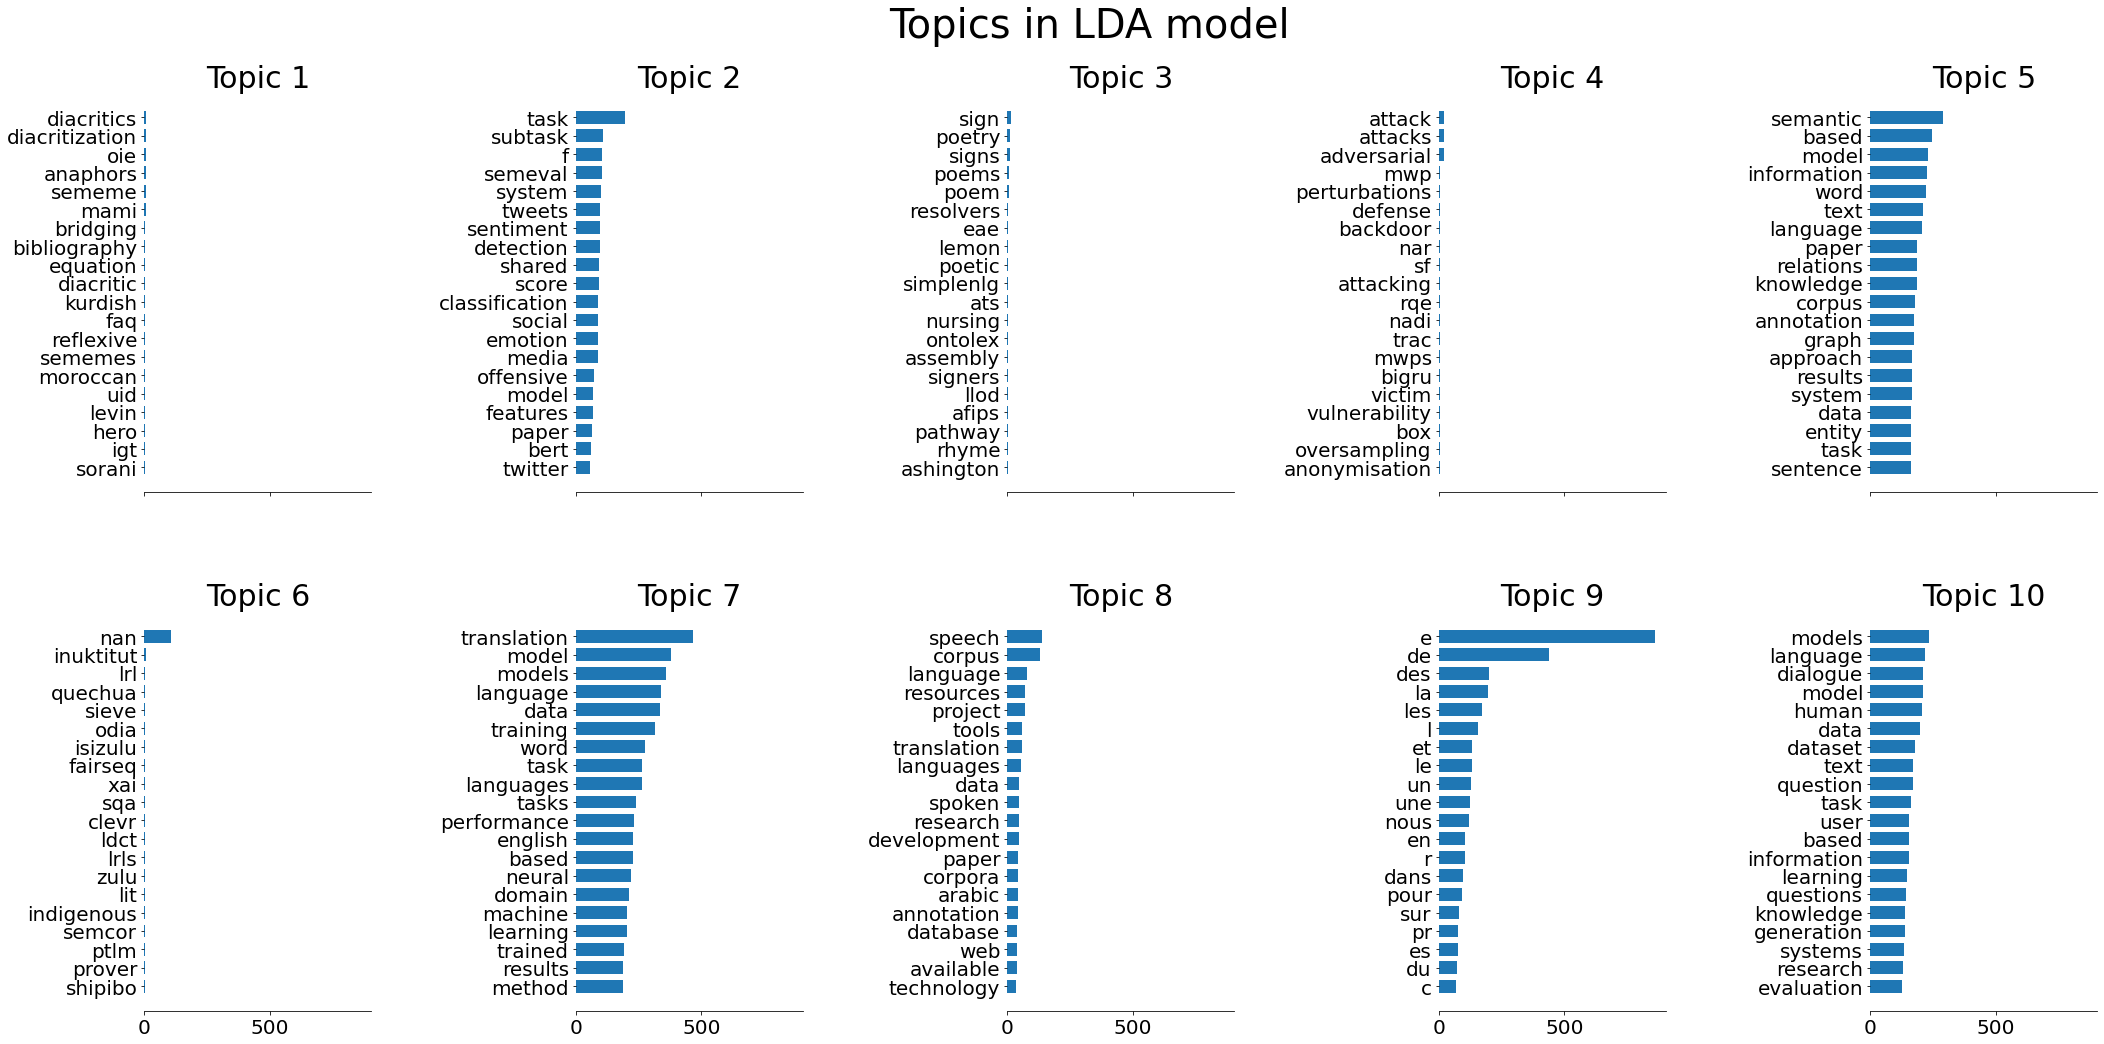

In [36]:
#### CODIGO Q ENCONTRE PARA GRAFICAR LOS TOPICS:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(35, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

#tf_vectorizer = CountVectorizer(
#    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
#)
tf_vectorizer = count_vect

#lda = LatentDirichletAllocation(
#    n_components=n_components,
#    max_iter=5,
#    learning_method="online",
#    learning_offset=50.0,
#    random_state=0,
#)

tf_feature_names = tf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

